In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.special import gammaln
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.linear_model import PoissonRegressor
import pyreadr
# matplotlibで日本語を使えるように
plt.rcParams["font.family"] = "IPAGothic"

In [2]:
data_chapter3 = pd.read_csv("../chapter3/data3a.csv")

In [3]:
Rdata_path = "data.RData"
# Rdataを読み込み
result = pyreadr.read_r(Rdata_path)
# dataは個体に対しての種子数のカウント数
data = result["m.data"]

<h1>4 一般化線形モデルのモデル選択</h1>

この章では「良い統計モデルとは何か？」あるいは「良いモデルを選び出す方法」を検討します  
複数の統計モデルの中から、何らかの意味で「良い」モデルを選ぶことをモデル選択と言います。  
たいていの場合、複雑なモデルほど観測データへのあてはまりは良くなるものの予測の面ではどうでしょうか？  
この章ではAICというモデル選択規準を使います。AICは「良い予測をするモデルが良いモデルである」という考えに基づいて  
設計された規準であり、「あてはまりの良さ重視」とは異なる考え方です。  

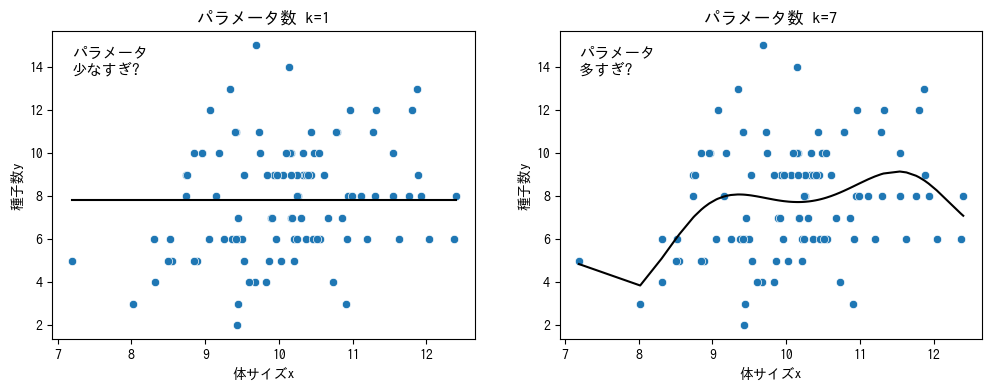

In [4]:
preds = []
texts = ["パラメータ\n少なすぎ?","パラメータ\n多すぎ?"]
titles = ["パラメータ数 k=1", "パラメータ数 k=7"]

# 説明変数に切片を追加
X = sm.add_constant(data_chapter3[["x"]])
# xの6次式までのデータを追加
for i in range(2,7):
  X[f"x_{i}"] = X["x"]**i

# 切片項のみのポアソン回帰
model = sm.GLM(data_chapter3["y"], X["const"], family=sm.families.Poisson()).fit()
preds.append(model.predict(X["const"]))
# xの6次式までをパラメータに取り入れたポアソン回帰
model = sm.GLM(data_chapter3["y"], X, family=sm.families.Poisson()).fit()
preds.append(model.predict(X))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1x2
for ax, pred, text, title in zip(axes, preds, texts, titles):
  sns.scatterplot(data_chapter3, x="x", y="y", ax=ax)
  x_sorted_idx = np.argsort(data_chapter3["x"])
  ax.plot(data_chapter3["x"].iloc[x_sorted_idx], pred.iloc[x_sorted_idx], color="black")
  ax.text(x=np.min(data_chapter3["x"]),y=np.max(data_chapter3["y"]),
          s=text, ha="left", va="top", fontsize=11)
  ax.set_xlabel("体サイズx")
  ax.set_ylabel("種子数y")
  ax.set_title(title)
plt.show()

<h1>4.1 データは一つ、モデルはたくさん</h1>

第２、３章では、統計モデルのパラメータを最尤推定したときに、対数尤度が「いま手元にある観測データへの当てはまりの良さ」であると考え、これを最大にするようなパラメータの値を探しました。  
このことからあるデータを説明する様々な統計モデルごとに決まる、最大対数尤度つまり「あてはまりのよさ」こそがモデルの良さであると考えればよいのでしょうか？  
実はそうではないだろうと言うのがこの章でのゴールになります

<h1>4.2 統計モデルの当てはまりの悪さ: 逸脱度</h1>

まず最初に、あてはまりの良さである最大対数尤度を変形した統計量である逸脱度について説明します。  
ここでは対数尤度$logL({\beta_j})$を$logL$と表記します。この$logL$を最大にするパラメータを探すのが最尤推定法です。  
また最大対数尤度を$logL^*$と表記します。  
逸脱度とは「あてはまりの良さ」ではなく「あてはまりの悪さ」を表現する指標で  
$D=-2logL^*$で定義され、あてはまりの良さである最大対数尤度$logL^*$に$-2$をかけているだけです。  
| 名前 | 定義 |
|------|-------|
| 逸脱度(D) | $-2logL^*$ |
| 最小逸脱度 | フルモデルをあてはめたときの逸脱度D |
| 残差逸脱度 | 逸脱度D - 最小の逸脱度D |
| 最大逸脱度 | Nullモデルをあてはめた時の逸脱度D |
| Null 逸脱度 | 最大の逸脱度D - 最小の逸脱度D |
  
この表の最小逸脱度とは何なのでしょうか？  
フルモデルと言われているモデルの逸脱度であり、第三章の例題だとデータ数が100個なので100個のパラメータを使って「あてはめた」モデルになります。  
もう少し詳しく言うと各個体の種子数を$y_i=\{6,6,6,12,10,…\}$とするとフルモデルでは  
・$i=\{1,2,3\}$の$y_i$は6なので$\{λ_1,λ_2,λ_3\}=\{6,6,6\}$  
・$i=4$の$y_4$は$12$なので$λ_4=12$  
・$i=5$の$y_5$は$10$なので$λ_5=10$  
・…(以下略)…  
フルモデルとはこのように100個のパラメータを使って「あてはめ」をする統計モデルです。  
つまりフルモデルとは全データを「読み上げている」ようなもので、統計モデルとしては価値がありません。  
しかしこのモデルをデータにあてはめたときに、ポアソン回帰で可能な他のどのモデルよりも「あてはまりの良さ」である対数尤度は大きくなります。  
  
反対に最大逸脱度とは「もっともあてはまりの悪いモデル」であり、この観測データにおけるポアソン回帰の場合では、  
パラメータ数の最も少ない切片$\beta_1$だけのモデル(パラメータ数$k=1$)となります。  
  
パラメータ数$k$さえ増やせば逸脱度はどんどん小さくなり、あてはまりの面では良くなります。


<h1>4.3 モデル選択基準AIC </h1>

パラメータ数の多い統計モデルほど、データへのあてはまりが良くなります。  
それは「たまたま得られたデータへのあてはめ向上に特化したもの」であり、その統計モデルの「予測の良さ」を損なっているかもしれません。  
そこでとあるモデル選択基準AIC(Akaike's infomation criterion)を導入します。  
AICは統計モデルのあてはまりの良さではなく、予測の良さを重視するモデル選択基準となっています。  
$
\begin{aligned}
AIC &= -2\{最大対数尤度 - 最尤推定したパラメータ数\} \\
    &= -2(logL^* - k) \\
    &= -2logL^* + 2k
\end{aligned}
$  
で定義され、逸脱度に対してパラメータ数の多さをペナルティ項として与えた選択規準になります。  
AICの最も小さいモデルが良いモデルとして評価されます。  

| モデル | パラメータ数k | 尤度($logL^*$) | 逸脱度($-2logL^*$) | 残差逸脱度 | AIC |
|------|-------|------|-------|------|-------|
| 一定 | 1 | -237.6 | 475.3 | 89.5 | 477.3 |
| f | 2 | -237.6 | 475.3 | 89.5 | 479.3 |
| x | 2 | -235.4 | 470.8 | 85.0 | 474.8 |
| x+f | 3 | -235.3 | 470.6 | 84.8 | 476.6 |
| フル | 100 | -192.9 | 385.8 | 0.0 | 585.8 |  
  
第3章で扱った各モデルを比較すると、xのみのモデルがAIC最小のモデルとして選択されます。  


<h1>4.4 AICを説明するためのまた別の例題</h1>

AICはなぜ統計モデルの予測量をあらわしているのか、その理由を考えるために第三章の例題を簡単にしたような新しい観測データを使います。  
この観測データには個体$i$の種子数$y_i$と体サイズ$x_i$が50個体分含まれています。  
ここでも応答変数は$y_i$でありこれはポアソン分布に従います。しかし説明変数$x_i$に関しては種子数$y_i$とは全く関係がないものとなっています。  
このデータに対して以下の二通りのポアソン回帰のモデルを比較検討します。  
・$logλ_i = \beta_1$  
・$logλ_i = \beta_1+\beta_2x_i$  
一定モデルでは切片$\beta_1$だけの線形予測子になっていますが、$x$モデルでは説明変数$x_i$とその係数$\beta_2$が加わっています。  
つまり一定モデルでは体サイズ$x_i$の影響がゼロであると考えていますが、$x$モデルでは正負いずれかはわからないけれど影響あり($\beta_2\neq0$)としています。  
これら二つのモデルを観測データにあてはめると、下の図のようになります。  


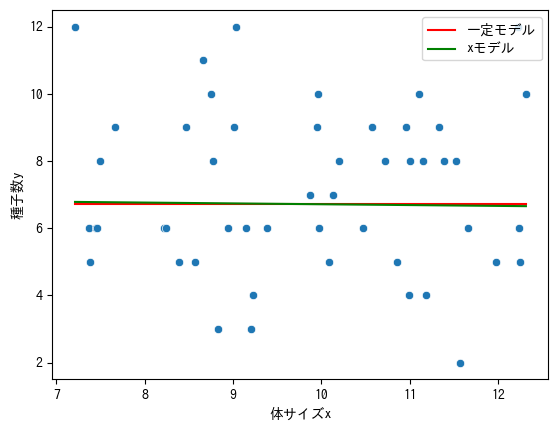

In [78]:
preds = []
colors = ["red", "green"]
labels = ["一定モデル","xモデル"]
y = data.iloc[:,0]
x = np.random.uniform(data_chapter3["x"].min(), data_chapter3["x"].max(), 50)
d = pd.DataFrame({"y":data_chapter3["y"].sample(50).to_numpy(), "x":x})
# 説明変数に切片を追加
X = sm.add_constant(d["x"])

# 切片項のみのポアソン回帰
model = sm.GLM(y, X["const"], family=sm.families.Poisson()).fit()
preds.append(model.predict(X["const"]))
# xモデルのポアソン回帰
model_x = sm.GLM(y, X, family=sm.families.Poisson()).fit()
preds.append(model_x.predict(X))

sns.scatterplot(d, x="x", y="y")
for pred,color,label in zip(preds, colors, labels):
  x_sorted_idx = np.argsort(d["x"])
  plt.plot(d["x"].iloc[x_sorted_idx], pred.iloc[x_sorted_idx], color=color, label=label)
plt.xlabel("体サイズx")
plt.ylabel("種子数y")
plt.legend(loc="upper right")
plt.show()

一方のモデルに他方のモデルが含まれているとき、ネストしているモデルといいます。  
この例題の場合、$x$モデルで$\beta_2=0$とおくと一定モデルになるのでこれらはネストしている関係になります。

<h1>4.5 なぜAICでモデル選択してよいのか？</h1>

まずは一定モデルをでーたにあてはめてみて、以下の問題について検討していきます。  
・AICで選ばれたモデルは何が「良い」のか  
・AIC=$-2(logL^*-k)$となるのはなぜか  
この章では具体的な数値例を示しながら  
・「統計モデルの予測の良さ」をあらわす平均対数尤度を図示する  
・観測データへの当てはまりの良さである最大対数油津尾のバイアス補正の方法の検討、平均対数尤度とAICの関係を考える  
といったことを見ていきます  

<h2>4.5.1 統計モデルの予測の良さ: 平均対数尤度<h2>

観測データを使って一定モデルのパラメータ$\beta_1$を最尤推定するところから始めましょう。  
一定モデルでは平均種子数$λ_i=exp(\beta_1)$で決まります。  
今回の例では観測データを生成した真の統計モデルでは平均$λ$は$8$と設定されていて、$\beta_1=log8=2.08$となっています。  
一方でサンプルサイズ50の観測データを使って最尤推定された$\hat\beta_1$は1.91となっています。  
  
最大対数尤度とはパラメータ推定に使った観測データ自身に対するあてはまりの良さであり、推定された統計モデルが真のモデルに似ているかどうかではなくたまたま得られた観測データへのあてはまりの良さと言えます。  
  
データ解析の狙いは、観測される現象の背後にある仕組みの特定、もしくはそれを近似的に代替しうる統計モデルの構築と考えてもいいでしょう。  
実際のデータ解析では「たまたま得られた」データへの当てはまりの良さを追求しがちです。例えば統計モデルをむやみに複雑にして「説明力」を高めればよいといった発想です。  
  
推定されたモデルが真のモデルに「どれくらい近いのか」を調べる方法はないのでしょうか?  
そのためには推定された統計モデルの予測の良さを評価するのが適切かもしれません。  
この例で言えば、予測の良さとは「次に同じデータ取得方法で別のデータを得たときに一定モデルはどれくらい正確にいいあてることができるのか」であり、観測データで推定された一定モデルが新データにどれくらいあてはまっているかを調べます。  
  
この例題では真の統計モデルがわかっているので、それを使って予測の良さ評価用のデータを生成してみましょう。  
真の統計モデル($λ=2.08$)に200セットのデータを生成させ、これらの予測の良さ評価用のデータたちに対してすでに推定された一定モデル($\hat\beta_1=1.91$)のあてはまりの良さを対数尤度で評価します。  
これら200個の対数尤度の平均が平均対数尤度となります。